<a href="https://colab.research.google.com/github/kevinkhu/exoplanet_atmospheres/blob/main/Exoplanet_Archive_Atmospheric_Retrieval_with_PLATON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASA Exoplanet Archive PLATON Atmospheric Retrieval
This notebook utilizes the PLanetary Atmospheric Transmission for Observer Noobs (PLATON) tool ([Zhang, M. et al., 2019](https://ui.adsabs.harvard.edu/abs/2019PASP..131c4501Z/abstract), [Zhang, M. et al., 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...899...27Z/abstract), [Source on Github](https://github.com/ideasrule/platon), [Documentation](https://platon.readthedocs.io)) for use with [Transmission Spectroscopy data](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive.

This notebook is meant to require minimal user input, unless you want to provide your own data. Each step will either begin with *(Play)* or **(Input)**. No editing is necessary for the *(Play)* steps, just hover over the cell and press the "Play" button on the left. The **(Input)** steps will tell you what can be changed.

**NOTE:** This has not been tested on all planets with transmission spectroscopy data on the Exoplanet Archive, so your results may vary!

**Estimated Runtime**: 1 hour

*Author*: [Kevin Hardegree-Ullman](http://kevinkhu.com)

*Last Modified*: April 14, 2021

1.   *(Play)* Install some dependencies and the PLATON package.



In [1]:
!apt-get install libopenblas-dev
!pip install git+https://github.com/ideasrule/platon.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-dev is already the newest version (0.2.20+ds-4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Cloning https://github.com/ideasrule/platon.git to /tmp/pip-req-build-yyh201e2
  Running command git clone -q https://github.com/ideasrule/platon.git /tmp/pip-req-build-yyh201e2
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 92kB 4.1MB/s 
     |████████████████████████████████| 163kB 13.0MB/s 
  Created wheel for platon: filename=platon-5.1.2-cp37-none-any.whl size=34388123 sha256=f4e1a6af610fcfd9e49f886416fa117932c9e0180d8ce6788c3329e710ec59d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ju11i0y/wheels/b6/0a/a3/dbb59b64ca49dafbd9e93ac0ad990ae2c878627722ebe406db
Successfully built p

2.   *(Play)* Import some packages!



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import io
import requests

from platon.fit_info import FitInfo
from platon.combined_retriever import CombinedRetriever
from platon.constants import R_sun, R_jup, M_jup, R_earth, M_earth
print('Packages successfully imported!')

Packages successfully imported!


3.   *(Play)* Read in the [transmission spectroscopy table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=transitspec) from the Exoplanet Archive and list the available planets.



In [3]:
url="https://www.dropbox.com/s/eteod7kpwpd95d8/transitspec_2021.04.08_11.45.14.csv?dl=1"
tstable=pd.read_csv(url, comment='#', header=0)
tstable.dropna(subset=['plnratror','bandwidth','centralwavelng'], inplace=True, axis=0)
tstable.sort_values('plntname',inplace=True)
tstable.reset_index(drop=True,inplace=True)

print('Here are all the available planets: ',tstable.plntname.unique())

Here are all the available planets:  ['55 Cnc e' 'CoRoT-1 b' 'GJ 1132 b' 'GJ 1214 b' 'GJ 3470 b' 'HAT-P-1 b'
 'HAT-P-12 b' 'HAT-P-16 b' 'HAT-P-18 b' 'HAT-P-19 b' 'HAT-P-26 b'
 'HAT-P-3 b' 'HAT-P-32 b' 'HD 189733 b' 'HD 209458 b' 'Qatar-1 b'
 'TRAPPIST-1 g' 'TrES-2 b' 'TrES-3 b' 'TrES-4 b' 'WASP-103 b' 'WASP-12 b'
 'WASP-121 b' 'WASP-127 b' 'WASP-17 b' 'WASP-19 b' 'WASP-21 b' 'WASP-31 b'
 'WASP-33 b' 'WASP-39 b' 'WASP-4 b' 'WASP-43 b' 'WASP-45 b' 'WASP-46 b'
 'WASP-52 b' 'WASP-6 b' 'WASP-67 b' 'WASP-69 b' 'WASP-74 b' 'WASP-80 b'
 'WASP-96 b' 'WASP-98 b' 'XO-2 N b']


4. **(Input)** Select your favorite planet from the list above.

In [4]:
planet = 'WASP-121 b' # Edit the name within the quotes. Make sure the exact string matches a planet in the list above.

if tstable['plntname'].str.contains(planet).any():
  print("You have selected planet "+planet+'.')
else:
  print("Please check your planet name, it doesn't appear to be in the list above.")

You have selected planet WASP-121 b.


5. *(Play)* Plot the data! Check that things look okay.

Text(0, 0.5, '$R_p/R_{\\star}$')

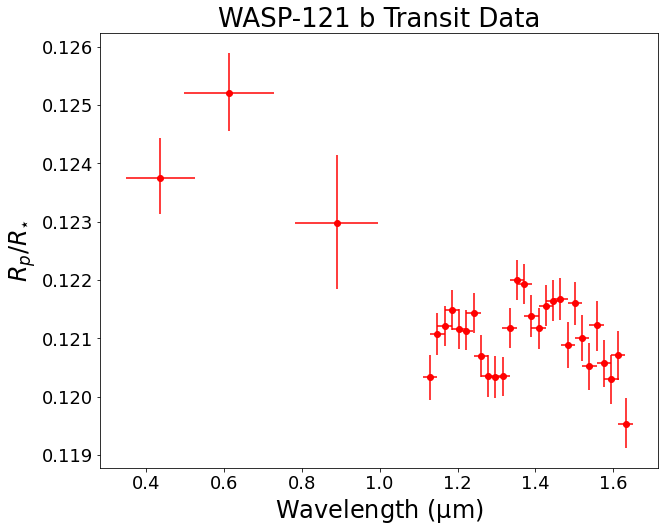

In [5]:
# Extract data from the table above for only the selected planet.
df = tstable.loc[(tstable['plntname'] == planet) & (tstable['centralwavelng'] > 0.3)] #This truncates the data to >0.3 microns, the limit of the models used below.
df = df.dropna(subset=['bandwidth', 'plnratror', 'plnratrorerr1', 'plnratrorerr2'])
df = df.sort_values(by='centralwavelng')
df = df.reset_index(drop=True)

# Make the plot
plt.figure(figsize=(10,8))
plt.title(planet+' Transit Data', fontsize=26)
plt.errorbar(x=df.centralwavelng,y=df.plnratror,xerr=df.bandwidth,yerr=[df.plnratrorerr1,-df.plnratrorerr2],fmt='o',color='red')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Wavelength ($\mathrm{\mu}$m)',fontsize=24)
plt.ylabel('$R_p/R_{\star}$',fontsize=24)

# plt.xscale('log') #uncomment if necessary

6. *(Play)* Download system parameter data from the Exoplanet Archive. 

In [6]:
p2ascii = planet.replace(" ","%20")

url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+pl_name+=+'"+p2ascii+"'+and+default_flag+=+1+&format=csv"

plsyspars=pd.read_csv(url, comment='#', header=0)
plsyspars

,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,disc_pubdate,disc_year,discoverymethod,disc_locale,disc_facility,disc_instrument,disc_telescope,disc_refname,ra,rastr,dec,decstr,glon,glat,elon,elat,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbperstr,pl_orblpererr1,pl_orblper,pl_orblpererr2,pl_orblperlim,pl_orblperstr,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,...,pl_nnotes,sy_pm,sy_pmerr1,sy_pmerr2,sy_pmstr,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pmdecstr,sy_plx,sy_plxerr1,sy_plxerr2,sy_plxstr,sy_dist,sy_disterr1,sy_disterr2,sy_diststr,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmagstr,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmagstr,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,WASP-121 b,b,WASP-121,NaN,NaN,TIC 22529346,Gaia DR2 5565050255701441664,1,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2016-06,2016,Transit,Ground,SuperWASP,e2v CCD Camera,Canon 200mm f/1.8L,<a refstr=DELREZ_ET_AL__2016 href=https://ui.a...,107.600231,07h10m24.06s,-39.097271,-39d05m50.17s,250.293703,-13.325136,118.743585,-60.792068,1.274925,2.000000e-07,-2.500000e-07,0,"<div><span class=supersubNumber"">1.27492550</s...",NaN,NaN,NaN,NaN,NaN,0.02544,0.00049,-0.0005,0,...,0,25.894035,0.041578,-0.041578,25.8940345&plusmn;0.0415779,-3.84814,0.039503,-0.039503,-3.8481400&plusmn;0.0395031,25.6065,0.041624,-0.041624,25.6065000&plusmn;0.0416236,3.67631,0.0214,-0.0214,3.67631&plusmn;0.02140,269.898,1.58,-1.562,"<div><span class=supersubNumber"">269.898</span...",10.997,0.088,-0.088,10.997&plusmn;0.088,10.514,0.006,-0.006,10.514&plusmn;0.006,9.625,0.021,-0.021,9.625&plusmn;0.021,9.439,0.025,-0.025,9.439&plusmn;0.025,9.374,0.022,-0.022


7. *(Play)* Take the basic planet and stellar parameters from the table above. Feel free to **(Input)** your own values if you have them.


In [7]:
#Reference quantities
R_earth = 6371009 #meters
R_jup = 69950000 #meters
R_sun = 695700000 #meters
M_earth = 5.97e24 #kilograms
M_jup = 1.898e27 #kilograms
M_sun = 1.988435e30 #kilograms
G = 6.6743015e-11 #m^3 kg^-1 s^-2

#Planet Parameters
R_guess = plsyspars['pl_rade'][0] * R_earth #Planet radius guess in Earth radii, if that wasn't obvious already
R_err = np.mean([np.abs(plsyspars['pl_radeerr1'][0]),np.abs(plsyspars['pl_radeerr2'][0])]) * R_earth #Planet radius error in Earth radii
print(planet+' Planet Parameters:')
print('R_planet = '+str(round(R_guess/R_earth,2))+' \u00B1 '+str(round(R_err/R_earth,2))+' R_Earth = '+str(round(R_guess/R_jup,2))+' \u00B1 '+str(round(R_err/R_jup,2))+' R_Jupiter')

M_pl = plsyspars['pl_bmasse'][0] * M_earth #Planet mass (or msini) in Earth masses
M_pl_err = np.mean([np.abs(plsyspars['pl_bmasseerr1'][0]),np.abs(plsyspars['pl_bmasseerr2'][0])]) * M_earth #Planet mass error in Earth masses
print('M_planet = '+str(round(M_pl/M_earth,2))+' \u00B1 '+str(round(M_pl_err/M_earth,2))+' M_Earth = '+str(round(M_pl/M_jup,2))+' \u00B1 '+str(round(M_pl_err/M_jup,2))+' M_Jupiter')

grav = G*M_pl/(R_guess**2)
print('Surface Gravity = '+str(round(grav,2))+' m/s^2')

T_guess = plsyspars['pl_eqt'][0] #Planet equilibrium temperature guess in Kelvin
print('T_eq = '+str(int(T_guess))+' K')
if T_guess < 300 or T_guess > 2600:
  print('*****STOP!***** T_eq is beyond the temperature range of the current model set. The following code will not work. Sorry :(')

#Stellar Host Parameters
Rs = plsyspars['st_rad'][0] * R_sun #Star radius in Sun radii
Rs_err = np.mean([np.abs(plsyspars['st_raderr1'][0]),np.abs(plsyspars['st_raderr2'][0])]) * R_sun #Star radius measurement error in Sun radii
print('\nStellar Host Parameters')
print('R_star = '+str(round(Rs/R_sun,2))+' \u00B1 '+str(round(Rs_err/R_sun,2))+' R_Sun')

T_star = plsyspars['st_teff'][0] #Star effective temperature in Kelvin
print('T_eff = '+str(int(T_star))+' K')

WASP-121 b Planet Parameters:
R_planet = 20.9 ± 0.49 R_Earth = 1.9 ± 0.04 R_Jupiter
M_planet = 375.99 ± 20.02 M_Earth = 1.18 ± 0.06 M_Jupiter
Surface Gravity = 8.45 m/s^2
T_eq = 2358 K

Stellar Host Parameters
R_star = 1.46 ± 0.03 R_Sun
T_eff = 6459 K


8. *(Play)* If you have values for planetary atmospheric metallicity (log Z) or the planetary C/O ratio, **(Input)** them below, otherwise leave them at the default values.

In [8]:
logZ_guess = 1.09 #Planetary atmospheric metallicity relative to the Sun. If you don't know this, set to 0.
CO_guess = 0.49 #Planetary C/O ratio. If you don't know this, set to 0.54 which is the solar value.
print('log(Z) = '+str(logZ_guess))
print('C/O = '+str(CO_guess))

log(Z) = 1.09
C/O = 0.49


9. *(Play)* *Run the PLATON retrieval!* This will run 1000 emcee steps and take ~**35 to 75 minutes** (typically depending on the amount of input data, on first run a 753MB file is also downloaded), so feel free to work on something else for about an hour... or if you're at home do yourself a favor and go bake some cookies! By the time the cookies are done, your code will have finished (probably), your place will smell like cookies, and, best of all, you'll have some cookies! After all 1000 steps have run, the best fit results will print below and also save to a file *BestFit.txt* in the Files panel to the left.

In [9]:
#Convert the data input to arrays
def winputs():
  wave_bins = []
  depths = []
  errors = []
  for i in range(len(df)):
    wave_bins.append([df['centralwavelng'][i]-df['bandwidth'][i]/2,df['centralwavelng'][i]+df['bandwidth'][i]/2])
    depths.append((df['plnratror'][i])**2)
    errors.append((df['plnratrorerr1'][i])**2)
  return 1e-6*np.array(wave_bins), np.array(depths), np.array(errors)

wbins, wdepths, werrors = winputs()
bins=wbins
depths=wdepths
errors=werrors

#create a Retriever object
retriever = CombinedRetriever()

#create a FitInfo object and set best guess parameters
fit_info = retriever.get_default_fit_info(
    Rs=Rs, Mp=M_pl, Rp=R_guess, T=T_guess,
    logZ=logZ_guess, CO_ratio=CO_guess, log_cloudtop_P=3,
    log_scatt_factor=0, scatt_slope=4, error_multiple=1, T_star=T_star)

#Add fitting parameters - this specifies which parameters you want to fit
#e.g. since we have not included cloudtop_P, it will be fixed at the value specified in the constructor

fit_info.add_gaussian_fit_param('Rs', Rs_err)
fit_info.add_gaussian_fit_param('Mp', M_pl_err)

# Here, emcee is initialized with walkers where R is between 0.9*R_guess and
# 1.1*R_guess.  However, the hard limit on R is from 0 to infinity.
fit_info.add_uniform_fit_param('Rp', 0, np.inf, 0.9*R_guess, 1.1*R_guess)

fit_info.add_uniform_fit_param('T', 1000, 3000, 0.5*T_guess, 1.5*T_guess)
fit_info.add_uniform_fit_param("log_scatt_factor", 0, 5, 0, 1)
fit_info.add_uniform_fit_param("logZ", -1, 3)
fit_info.add_uniform_fit_param("log_cloudtop_P", -0.99, 5)
fit_info.add_uniform_fit_param("error_multiple", 0, np.inf, 0.5, 5)

#Use Nested Sampling to do the fitting
result = retriever.run_emcee(bins, depths, errors,
                             None, None, None,
                             fit_info, nwalkers=50, nsteps=1000,
                             rad_method="xsec" #"ktables" for corr-k
)

with open("example_retrieval_result.pkl", "wb") as f:
    pickle.dump(result, f)

#Useful members: result.chain, result.lnprobability, result.flatchain, result.flatlnprobability

Data URL https://sites.astro.caltech.edu/platon/data_adb9ee511904717bf864786dcddcbacc.zip
753 MB  [100%]
Extracting...
Extraction finished!


/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Step 10: ln_prob=-4.12e+08	Rs=1.43 R_sun	Mp=1.20 M_jup	Rp=1.76 R_jup	T=1815 K	log_scatt_factor=0.34 	logZ=1.26 	log_cloudtop_P=0.96 	error_multiple=4.33 	
Step 20: ln_prob=-1.87e+09	Rs=1.46 R_sun	Mp=1.24 M_jup	Rp=1.85 R_jup	T=2538 K	log_scatt_factor=0.71 	logZ=1.55 	log_cloudtop_P=1.84 	error_multiple=2.95 	
Step 30: ln_prob=-6.63e+08	Rs=1.51 R_sun	Mp=1.17 M_jup	Rp=1.85 R_jup	T=1671 K	log_scatt_factor=0.74 	logZ=1.81 	log_cloudtop_P=3.03 	error_multiple=2.76 	
Step 40: ln_prob=-4.58e+07	Rs=1.47 R_sun	Mp=1.11 M_jup	Rp=1.75 R_jup	T=2143 K	log_scatt_factor=1.00 	logZ=2.67 	log_cloudtop_P=1.94 	error_multiple=3.84 	
Step 50: ln_prob=-4.68e+07	Rs=1.47 R_sun	Mp=1.12 M_jup	Rp=1.74 R_jup	T=2071 K	log_scatt_factor=1.04 	logZ=2.25 	log_cloudtop_P=1.94 	error_multiple=4.58 	
Step 60: ln_prob=-3.12e+07	Rs=1.42 R_sun	Mp=1.25 M_jup	Rp=1.65 R_jup	T=1908 K	log_scatt_factor=0.35 	logZ=0.49 	log_cloudtop_P=1.75 	error_multiple=4.84 	
Step 70: ln_prob=-2.75e+05	Rs=1.40 R_sun	Mp=1.33 M_jup	Rp=1.60 R_jup	T

/usr/local/lib/python3.7/dist-packages/platon/_params.py:59: RuntimeWarning: divide by zero encountered in log
  return np.log(scipy.stats.norm.pdf(value, self.best_guess, self.std))


Atmosphere unbound: height > hill radius
Step 190: ln_prob=-2.01e+04	Rs=1.05 R_sun	Mp=1.58 M_jup	Rp=1.21 R_jup	T=2150 K	log_scatt_factor=0.87 	logZ=0.41 	log_cloudtop_P=2.75 	error_multiple=23.81 	
Step 200: ln_prob=-7.56e+04	Rs=1.13 R_sun	Mp=1.20 M_jup	Rp=1.30 R_jup	T=1929 K	log_scatt_factor=1.27 	logZ=2.42 	log_cloudtop_P=2.10 	error_multiple=28.67 	
Step 210: ln_prob=-1.53e+04	Rs=1.03 R_sun	Mp=1.41 M_jup	Rp=1.18 R_jup	T=2165 K	log_scatt_factor=1.38 	logZ=1.16 	log_cloudtop_P=2.51 	error_multiple=27.38 	
Atmosphere unbound: height > hill radius
Step 220: ln_prob=-1.27e+04	Rs=0.98 R_sun	Mp=1.42 M_jup	Rp=1.12 R_jup	T=2218 K	log_scatt_factor=1.56 	logZ=1.23 	log_cloudtop_P=2.32 	error_multiple=28.68 	
Step 230: ln_prob=-3.99e+04	Rs=1.09 R_sun	Mp=1.64 M_jup	Rp=1.21 R_jup	T=2714 K	log_scatt_factor=0.90 	logZ=0.97 	log_cloudtop_P=0.75 	error_multiple=24.74 	
Step 240: ln_prob=-5.17e+04	Rs=0.85 R_sun	Mp=0.60 M_jup	Rp=0.96 R_jup	T=2298 K	log_scatt_factor=1.88 	logZ=1.39 	log_cloudtop_P=2.15 

10. *(Play)* Plot your data and best fit retrieved spectrum. This will also save a file called *planet name*_best_fit.png in the Files panel to the left.


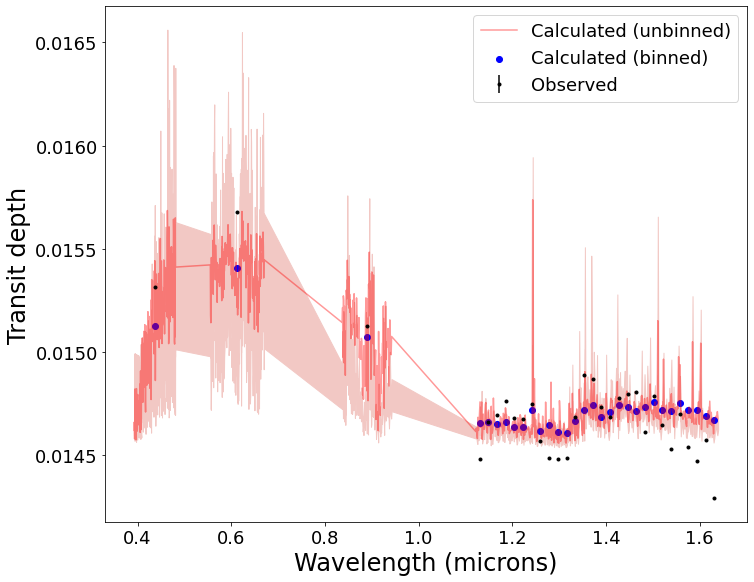

In [10]:
plt.figure(figsize=(10,8))
result.plot_spectrum(planet+"_best_fit")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Wavelength (microns)',fontsize=24)
plt.ylabel('Transit depth',fontsize=24)
plt.xscale('linear') #uncomment as needed
plt.legend(fontsize='18')

11. *(Play)* Plot the 2D posteriors from the atmospheric retrieval. This will also save a file called *planet name*_emcee_corner.png in the sample_data folder to the left. If your posteriors do not look great, you might want to tune the parameters in Steps 7 and 8.

<Figure size 432x288 with 0 Axes>

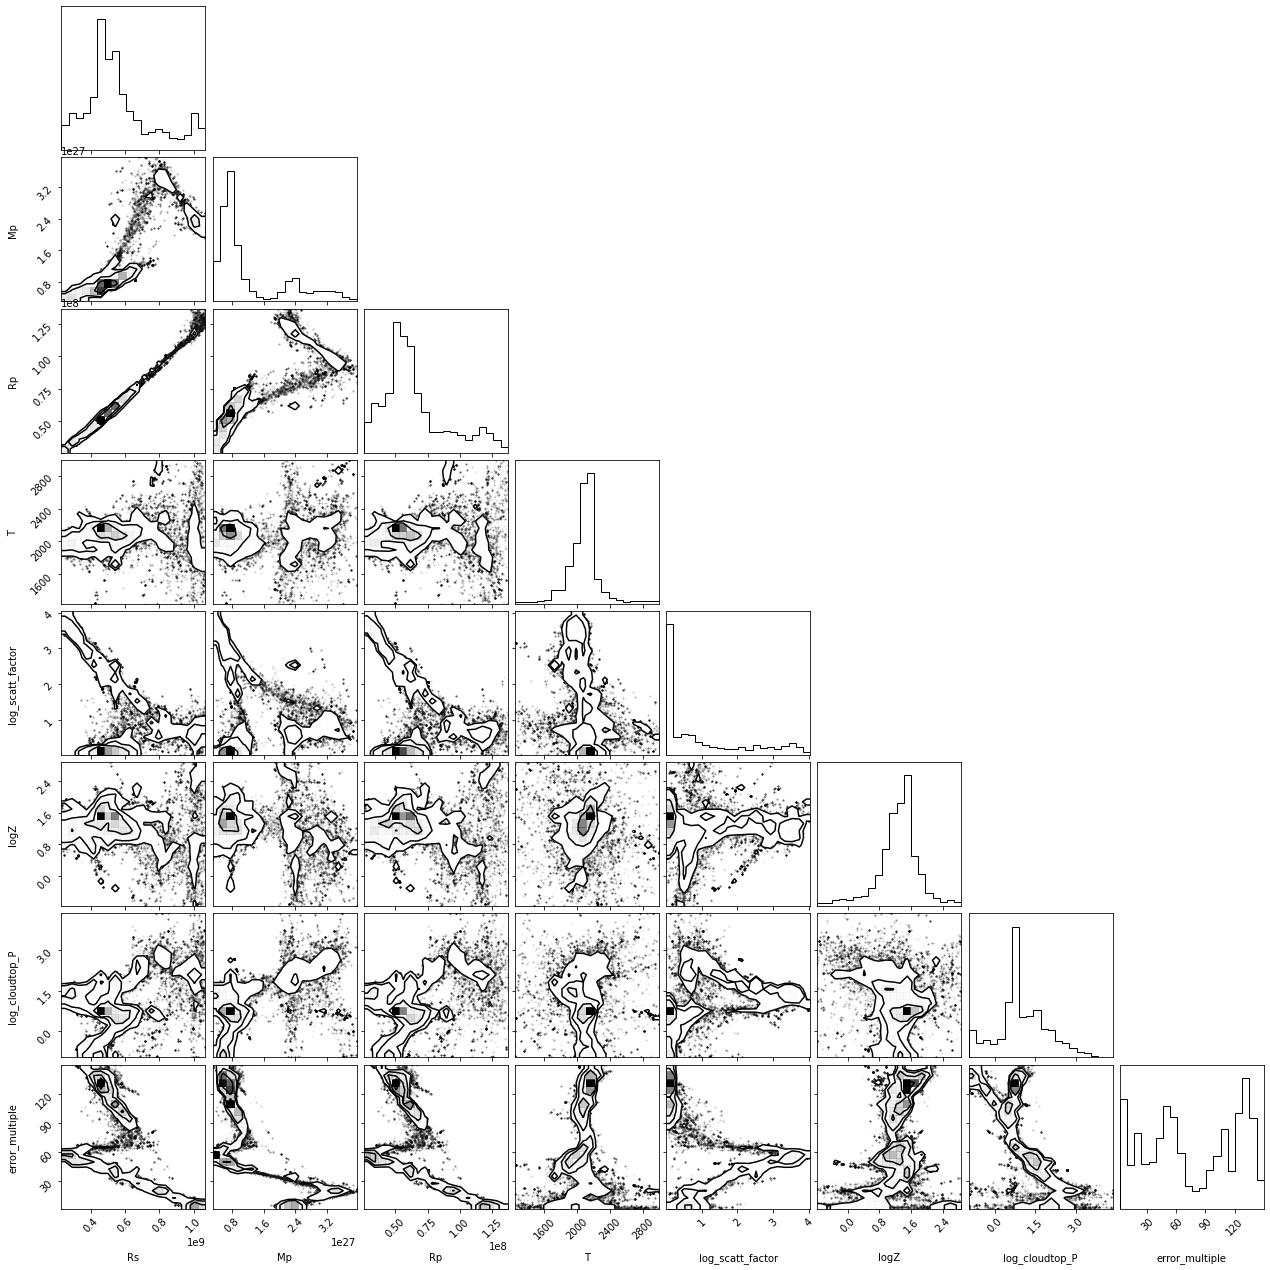

In [11]:
result.plot_corner(planet+"_emcee_corner.png")

You have reached the end of this tutorial, congratulations!

#Development Roadmap

*   Edit for easy user upload of their own data.
*   Edit to allow/convert different transit depth parameters (e.g., Rp/Rs, (Rp/Rs)^2, %, mmag).
*   Acquire transit data from community repositories (e.g., [Exoplanet Watch](https://exoplanets.nasa.gov/exoplanet-watch/about-exoplanet-watch/overview/)).
*   Color transit data by input source to allow checking for inconsistent data or removing sources.
*   Allow for combining/averaging measurements at the same wavelength/bandpass.